<a href="https://colab.research.google.com/github/shreyab375/LSTM-Forecasting-Models-/blob/main/LSTM_in_SN_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import joblib
import pandas as pd
import datetime
import tensorflow as tf
import os
import random
import timeit
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Bidirectional, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import RootMeanSquaredError


The data can be found in https://www.sidc.be/SILSO/INFO/sndtotcsv.php

In [18]:
#Reade the data
df_sn=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/snv1_full.csv', sep=",", header=0)
#convert the date to datetime format
df_sn.Date = pd.to_datetime(df_sn.Date)

In [19]:
df_sn.tail()

,Date,Sn
72098,2015-05-27,9
72099,2015-05-28,8
72100,2015-05-29,22
72101,2015-05-30,19
72102,2015-05-31,17


In [20]:
#Select the values from 1900 to avoid any data gaps
df_sn = df_sn.set_index('Date')
df_sn = df_sn.truncate(before = '1900-01-01', after ='2024-01-01')
df_sn = df_sn.reset_index()

In [21]:
#Step 3
# Split the data into training, validation, and test sets
n = len(df_sn)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_data = df_sn[:n_train].drop(columns='Date').values
train_date = df_sn[:n_train].drop(columns=['Sn'])

val_data   = df_sn[n_train:n_train+n_val].drop(columns='Date').values
val_date   = df_sn[n_train:n_train+n_val].drop(columns=['Sn'])

test_data  = df_sn[-n_test:].drop(columns=['Date']).values
test_date  = df_sn[-n_test:].drop(columns=['Sn'])


In [22]:
test_date

,Date
37938,2003-11-15
37939,2003-11-16
37940,2003-11-17
37941,2003-11-18
37942,2003-11-19
...,...
42149,2015-05-27
42150,2015-05-28
42151,2015-05-29
42152,2015-05-30


In [23]:
print('Train Set      : ',len(train_data))
print('Validation Set : ',len(val_data))
print('Test Set       : ',len(test_data))

Train Set      :  33723
Validation Set :  4215
Test Set       :  4216


In [24]:
#Step 4
# Normalize the data using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
val_data   = scaler.transform(val_data)
test_data  = scaler.transform(test_data)

In [25]:
#Step 5
# Prediction intervals
ten_days = 10
hundred_days = 100
one_year = 365
ten_years = 3650

# Prepare the datasets
ten_day_date = test_date.head(ten_days)
ten_day_data = test_data[:ten_days]

hundred_day_date = test_date.head(hundred_days)
hundred_day_data = test_data[:hundred_days]

one_year_date = test_date.head(one_year)
one_year_data = test_data[:one_year]

ten_year_date = test_date.head(ten_years)
ten_year_data = test_data[:ten_years]

In [26]:
#Step 6
#Create a windowed dataset for training
# Assume test_data is your feature (e.g., SN) and is a numpy array
def reshape_data(data, time_steps):
    X = []
    y = []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [27]:
train_data

array([[-0.95079432],
       [-0.95079432],
       [-1.03742334],
       ...,
       [ 0.60852811],
       [ 0.46992167],
       [ 0.31398943]])

In [28]:
original_data = scaler.inverse_transform(train_data)
original_data

array([[ 7.],
       [ 7.],
       [ 2.],
       ...,
       [97.],
       [89.],
       [80.]])

In [29]:
#Step 7
#Let's create a time step of 10 days
## Example: Predict for 10 days (using 10 days history to predict the next day)
time_steps = 10
X_train, y_train = reshape_data(train_data, time_steps)
X_val, y_val     = reshape_data(val_data, time_steps)
X_test, y_test   = reshape_data(test_data, time_steps)

In [30]:
#Step 8
def cc(y_true, y_pred):
    """
    Compute the correlation coefficient between y_true and y_pred.
    """
    # Compute the covariance matrix
    cov = tfp.stats.covariance(y_true, y_pred, sample_axis=0)

    # Compute the standard deviation of y_true and y_pred
    std_true = K.std(y_true)
    std_pred = K.std(y_pred)

    # Compute the correlation coefficient
    return cov / (std_true * std_pred)


In [50]:
# Example: Input shape = (time steps, features)
input_shape = (10, 1)  # Modify for different horizons (e.g., 10 days, 100 days, etc.)
model = Sequential([
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(32)),

    Dense(32, activation='relu'),
    Dense(1)
])


In [51]:

optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)
model.compile(optimizer= optimizer,
              loss=tf.keras.losses.Huber(),
              metrics= [RootMeanSquaredError(), cc])

In [53]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5, verbose=1,
                               mode='min',
                               restore_best_weights=True)


In [54]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [55]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping])

Epoch 1/50
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - cc: nan - loss: 0.4360 - root_mean_squared_error: 1.0263 - val_cc: nan - val_loss: 0.2757 - val_root_mean_squared_error: 0.7720
Epoch 2/50
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - cc: nan - loss: 0.3683 - root_mean_squared_error: 0.9427 - val_cc: nan - val_loss: 0.2428 - val_root_mean_squared_error: 0.7213
Epoch 3/50
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - cc: nan - loss: 0.3280 - root_mean_squared_error: 0.8842 - val_cc: nan - val_loss: 0.2119 - val_root_mean_squared_error: 0.6711
Epoch 4/50
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - cc: nan - loss: 0.2869 - root_mean_squared_error: 0.8187 - val_cc: nan - val_loss: 0.1797 - val_root_mean_squared_error: 0.6146
Epoch 5/50
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - cc: nan - loss: 0.2485 - root_mean_squared_error: 0.7573 - val_cc: nan - val_loss: 0.1494 - val_root_mean_squared_error: 0.5575
Epoch 6/50
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - cc: nan - loss: 0.

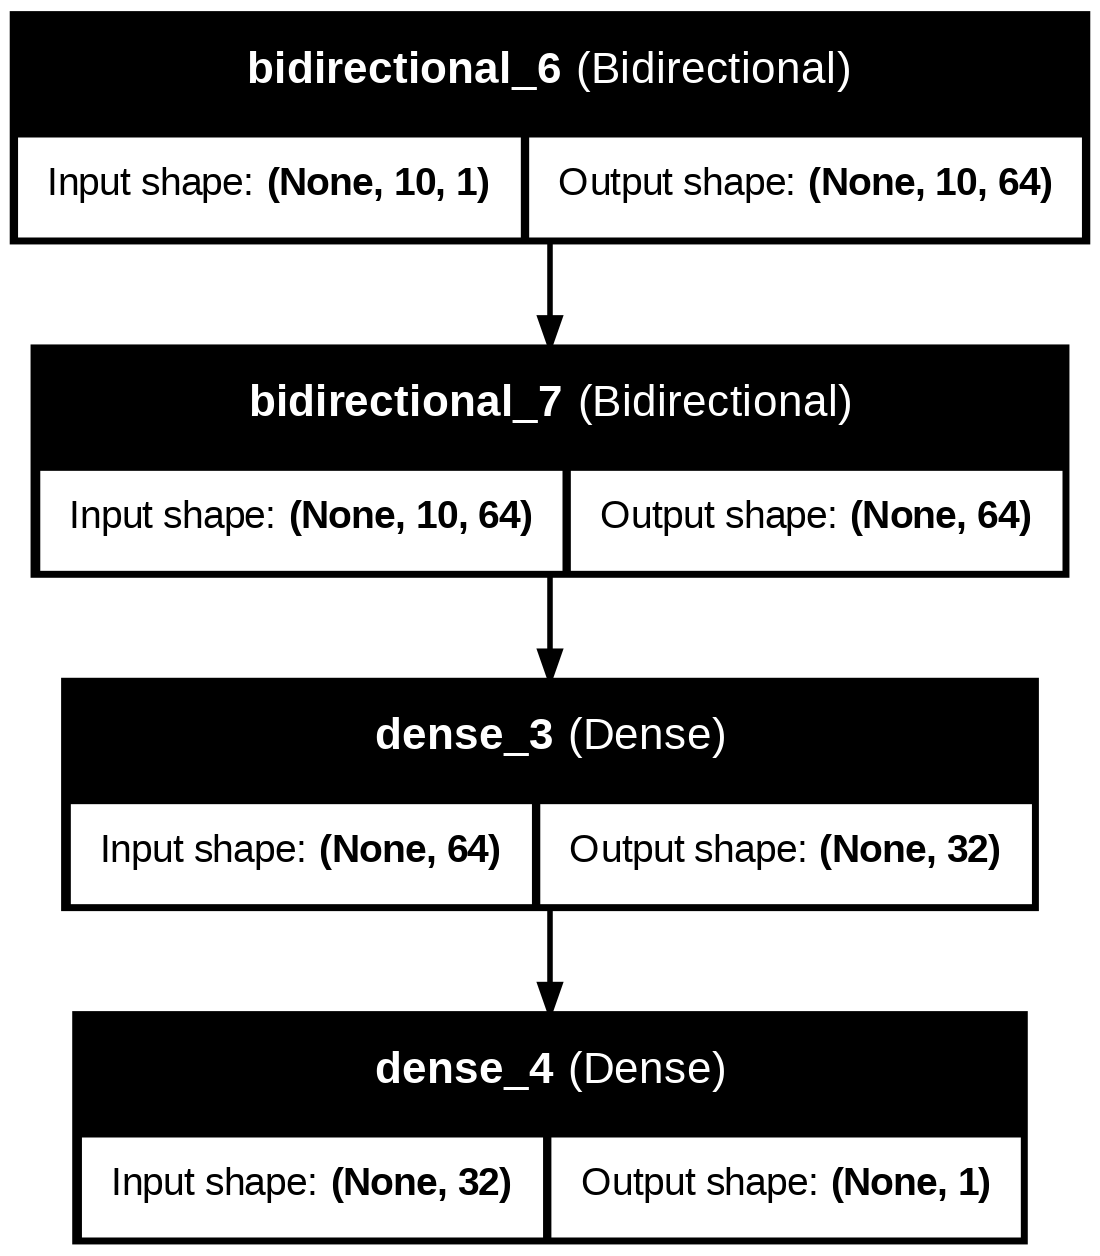

<Figure size 500x500 with 0 Axes>

In [60]:
from tensorflow.keras.utils import plot_model
plt.figure(figsize=(5, 5))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

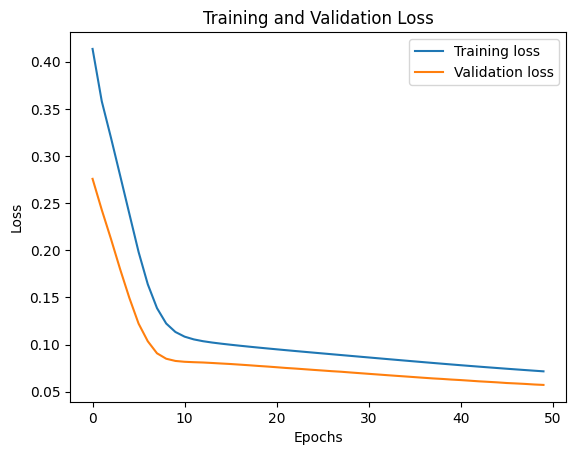

In [61]:
# Plot the training and validation metrics
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

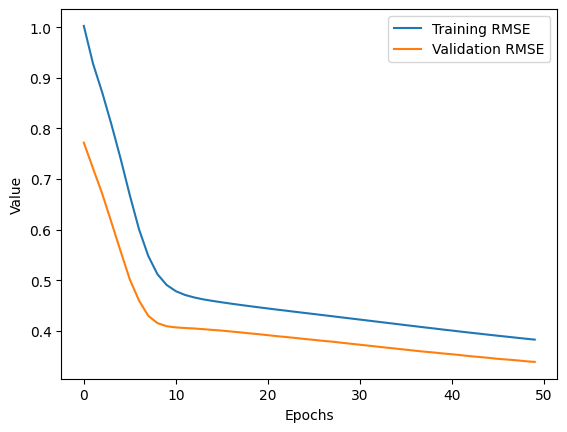

In [62]:
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [65]:
# Evaluate the model on the test set
test_loss, test_rmse, test_cc = model.evaluate(X_test, y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cc: 0.4587 - loss: 0.0267 - root_mean_squared_error: 0.2279
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


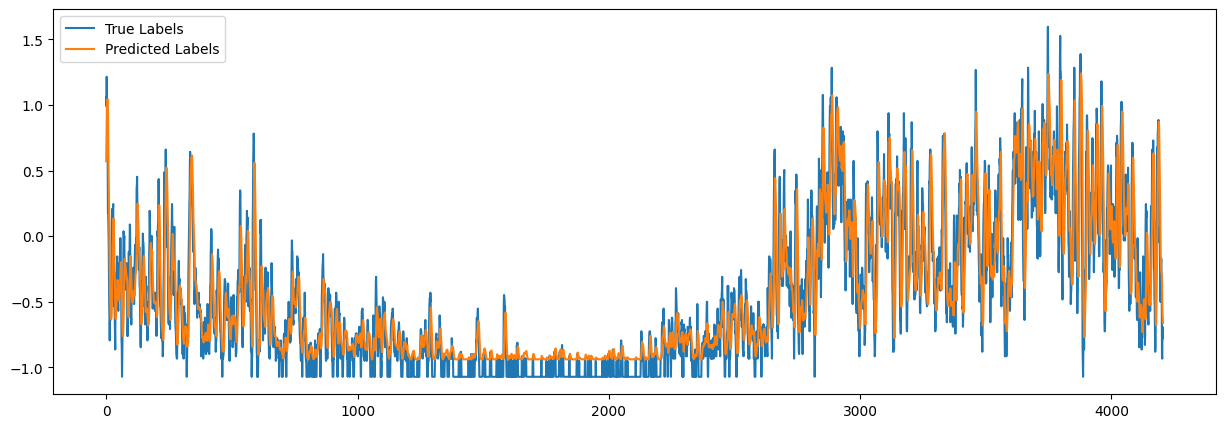

In [66]:
# Plot the predicted and true labels
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='True Labels')
plt.plot(y_pred, label='Predicted Labels')
plt.legend()
plt.show()

In [67]:
y_test.shape

(4206, 1)

In [68]:
#Step 9
#Evaluate the model on the 10, 100, 356 Days to Forecast
X_one   = X_test[:10]
X_three = X_test[:100]
X_seven = X_test[:365]

y_one   = y_test[:10]
y_three = y_test[:100]
y_seven = y_test[:365]

print("10 Day to Forecast")
test_loss, test_rmse, test_cc = model.evaluate(X_one, y_one)
y_pred_one = model.predict(X_one)


print("100 Days to Forecast")
test_loss, test_rmse, test_cc = model.evaluate(X_three, y_three)
y_pred_three = model.predict(X_three)

print("365 Days to Forecast")
test_loss, test_rmse, test_cc = model.evaluate(X_seven, y_seven)
y_pred_seven = model.predict(X_seven)

10 Day to Forecast
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - cc: 0.1437 - loss: 0.0995 - root_mean_squared_error: 0.4461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
100 Days to Forecast
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - cc: 0.5063 - loss: 0.0624 - root_mean_squared_error: 0.3515
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
365 Days to Forecast
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - cc: 0.5161 - loss: 0.0484 - root_mean_squared_error: 0.3088
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [69]:
#Step 10
#Inverse from scaled data
inv_pred_one = scaler.inverse_transform(y_pred_one)
inv_one      = scaler.inverse_transform(y_one)

inv_pred_three = scaler.inverse_transform(y_pred_three)
inv_three      = scaler.inverse_transform(y_three)

inv_pred_seven = scaler.inverse_transform(y_pred_seven)
inv_seven      = scaler.inverse_transform(y_seven)

#Copy data date
viz_one   = ten_day_date.copy()
viz_three = hundred_day_date.copy()
viz_seven = one_year_date.copy()

#Join true and predicted data
viz_one['load_pred'] = inv_pred_one
viz_one['load_true'] = inv_one

viz_three['load_pred'] = inv_pred_three
viz_three['load_true'] = inv_three

viz_seven['load_pred'] = inv_pred_seven
viz_seven['load_true'] = inv_seven

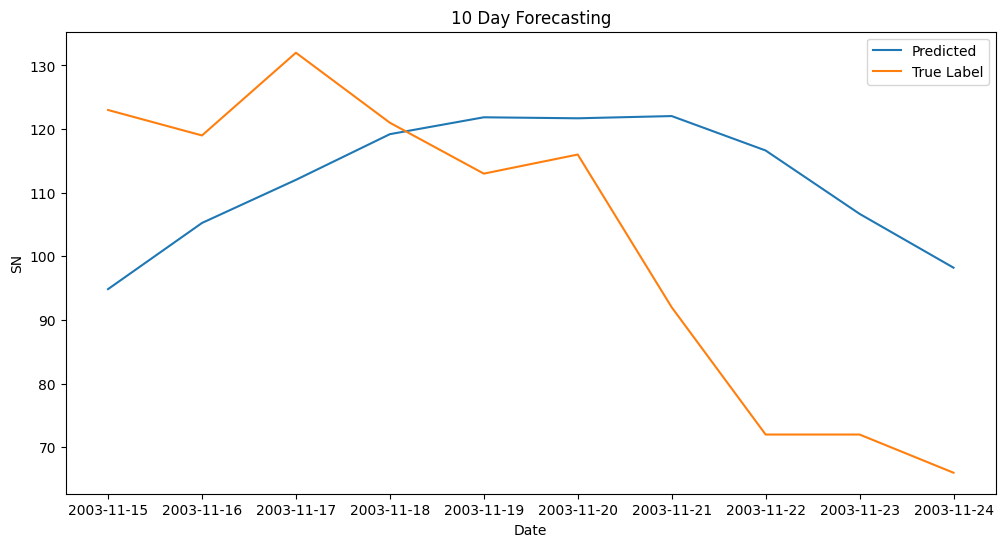

In [73]:
#10 Day Forecasting

# Load dataset
#viz_one = viz_one.set_index('Date')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_one.index, viz_one['load_pred'], label='Predicted')
ax.plot(viz_one.index, viz_one['load_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('SN')
ax.set_title('10 Day Forecasting')
ax.legend()

# Show plot
plt.show()

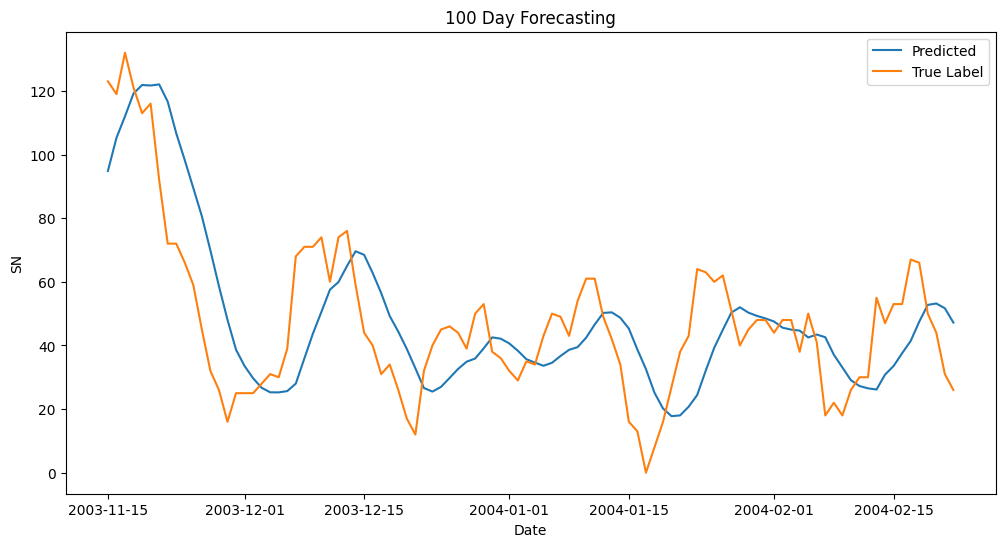

In [74]:
#100 Days Forecasting

# Load dataset
viz_three = viz_three.set_index('Date')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_three.index, viz_three['load_pred'], label='Predicted')
ax.plot(viz_three.index, viz_three['load_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('SN')
ax.set_title('100 Day Forecasting')
ax.legend()

# Show plot
plt.show()


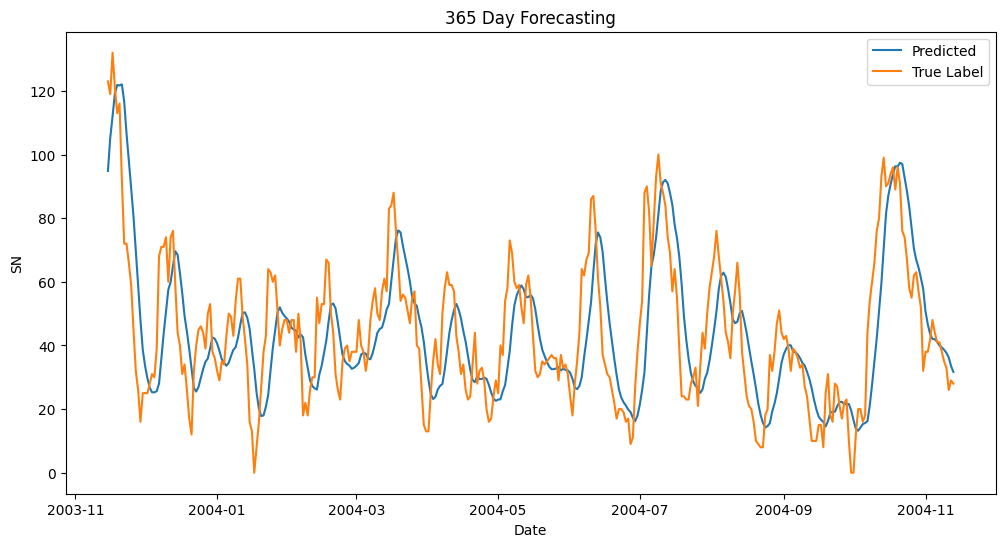

In [75]:
#365 Days Forecasting

# Load dataset
viz_seven = viz_seven.set_index('Date')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_seven.index, viz_seven['load_pred'], label='Predicted')
ax.plot(viz_seven.index, viz_seven['load_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('SN')
ax.set_title('365 Day Forecasting')
ax.legend()

# Show plot
plt.show()




In [76]:
import pickle

# Save the trained model
model.save('/content/drive/MyDrive/Model/BiLSTM_Model_Final.h5')

# Save the history object
with open('/content/drive/MyDrive/Model/BiLSTM_history_Final.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [78]:
#Use Model To Forecasting
#Load Library, Model, and Addition First

In [79]:
#1. Merge array data for base predict
x_data = np.vstack((X_train, X_val, X_test))
x_data

array([[[-0.95079432],
        [-0.95079432],
        [-1.03742334],
        ...,
        [-1.07207495],
        [-1.07207495],
        [-1.07207495]],

       [[-0.95079432],
        [-1.03742334],
        [-1.07207495],
        ...,
        [-1.07207495],
        [-1.07207495],
        [-1.07207495]],

       [[-1.03742334],
        [-1.07207495],
        [-1.07207495],
        ...,
        [-1.07207495],
        [-1.07207495],
        [-0.84683949]],

       ...,

       [[-0.18845891],
        [-0.39636856],
        [-0.50032339],
        ...,
        [-0.46567178],
        [-0.91614271],
        [-0.93346851]],

       [[-0.39636856],
        [-0.50032339],
        [-0.24043632],
        ...,
        [-0.91614271],
        [-0.93346851],
        [-0.69090724]],

       [[-0.50032339],
        [-0.24043632],
        [-0.24043632],
        ...,
        [-0.93346851],
        [-0.69090724],
        [-0.74288466]]])

In [80]:
x_data.shape

(42124, 10, 1)

In [81]:
#2. test model prediction
import numpy as np

# Set the window size and n_steps
n_steps = 100 # 100 days

# Get the last window_size data points
start_index = len(x_data) - n_steps
n_step = x_data[start_index:]

# Make the predictions
y_pred = model.predict(n_step)

# Print the predicted values
print(y_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[[-0.3549355 ]
 [-0.3639906 ]
 [-0.41221914]
 [-0.4424383 ]
 [-0.47962797]
 [-0.5575168 ]
 [-0.62108153]
 [-0.61465406]
 [-0.587911  ]
 [-0.53680015]
 [-0.52250105]
 [-0.5272212 ]
 [-0.54575336]
 [-0.58519745]
 [-0.6025923 ]
 [-0.6579277 ]
 [-0.68800247]
 [-0.71798056]
 [-0.731863  ]
 [-0.70172095]
 [-0.6446153 ]
 [-0.5518549 ]
 [-0.5096255 ]
 [-0.48331422]
 [-0.48011217]
 [-0.4970307 ]
 [-0.51081604]
 [-0.50853294]
 [-0.58117265]
 [-0.63072675]
 [-0.55222607]
 [-0.42546165]
 [-0.2838415 ]
 [-0.1726717 ]
 [-0.06045514]
 [ 0.02629766]
 [ 0.01969537]
 [-0.00769742]
 [-0.1053698 ]
 [-0.23893957]
 [-0.32898077]
 [-0.42549556]
 [-0.50925094]
 [-0.5219457 ]
 [-0.52200586]
 [-0.5136015 ]
 [-0.50710106]
 [-0.5147046 ]
 [-0.5104865 ]
 [-0.5253576 ]
 [-0.49451742]
 [-0.40022945]
 [-0.27395135]
 [-0.15279031]
 [-0.06353862]
 [ 0.00703862]
 [ 0.14103466]
 [ 0.31843293]
 [ 0.45844454]
 [ 0.52150446]
 [ 0.5584148 ]
 [ 0.6311497 ]
 [ 0.6062139 ]
 [ 0.48126137]
 [

In [82]:
#3. Invers to original data
inv_data = scaler.inverse_transform(y_pred)
inv_data

array([[ 41.391407],
       [ 40.86877 ],
       [ 38.085148],
       [ 36.340977],
       [ 34.194485],
       [ 29.698944],
       [ 26.030155],
       [ 26.401134],
       [ 27.944672],
       [ 30.894657],
       [ 31.719963],
       [ 31.447529],
       [ 30.377901],
       [ 28.101292],
       [ 27.09731 ],
       [ 23.903492],
       [ 22.167656],
       [ 20.4374  ],
       [ 19.636139],
       [ 21.375862],
       [ 24.671848],
       [ 30.025736],
       [ 32.463108],
       [ 33.981728],
       [ 34.16654 ],
       [ 33.190044],
       [ 32.394394],
       [ 32.52617 ],
       [ 28.333591],
       [ 25.473461],
       [ 30.004314],
       [ 37.320824],
       [ 45.49477 ],
       [ 51.911198],
       [ 58.388042],
       [ 63.395187],
       [ 63.01412 ],
       [ 61.43308 ],
       [ 55.795685],
       [ 48.086388],
       [ 42.889446],
       [ 37.318867],
       [ 32.484726],
       [ 31.752016],
       [ 31.748545],
       [ 32.233624],
       [ 32.60881 ],
       [ 32.1

In [84]:
#4. Copy Dataframe
viz = df_sn.copy()
viz

,Date,Sn
0,1900-01-01,7
1,1900-01-02,7
2,1900-01-03,2
3,1900-01-04,0
4,1900-01-05,0
...,...,...
42149,2015-05-27,9
42150,2015-05-28,8
42151,2015-05-29,22
42152,2015-05-30,19


In [86]:
#5. Generate new forecasting date
from prophet import Prophet
m = Prophet()

viz = viz.rename(columns={'Date': 'ds', 'Sn' : 'y'})

m.fit(viz)
future = m.make_future_dataframe(periods=n_steps, freq='D', include_history=False)
future

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4x58bq8z/7w3h84s9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4x58bq8z/hhmrsz_x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83318', 'data', 'file=/tmp/tmp4x58bq8z/7w3h84s9.json', 'init=/tmp/tmp4x58bq8z/hhmrsz_x.json', 'output', 'file=/tmp/tmp4x58bq8z/prophet_modeluxgb_351/prophet_model-20240827110433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:04:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:05:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds
0,2015-06-01
1,2015-06-02
2,2015-06-03
3,2015-06-04
4,2015-06-05
...,...
95,2015-09-04
96,2015-09-05
97,2015-09-06
98,2015-09-07


In [87]:
#6. Merge Forecasting Date and Data
future['Sn'] = inv_data
future = future.rename(columns={'ds': 'Date'})
future

,Date,Sn
0,2015-06-01,41.391407
1,2015-06-02,40.868771
2,2015-06-03,38.085148
3,2015-06-04,36.340977
4,2015-06-05,34.194485
...,...,...
95,2015-09-04,41.680016
96,2015-09-05,34.254345
97,2015-09-06,28.309666
98,2015-09-07,26.067204


In [91]:
#7. Copy historical data for Visualization
history_predict = n_steps #Set by window_size, 100 days

hist_data = df_sn.copy()
hist_data

start_index = len(hist_data) - history_predict
hist_data = hist_data[start_index:]

In [92]:
len(hist_data)

100

In [95]:
#8. Set Index
hist_data = hist_data.set_index('Date')
future_data = future.set_index('Date')


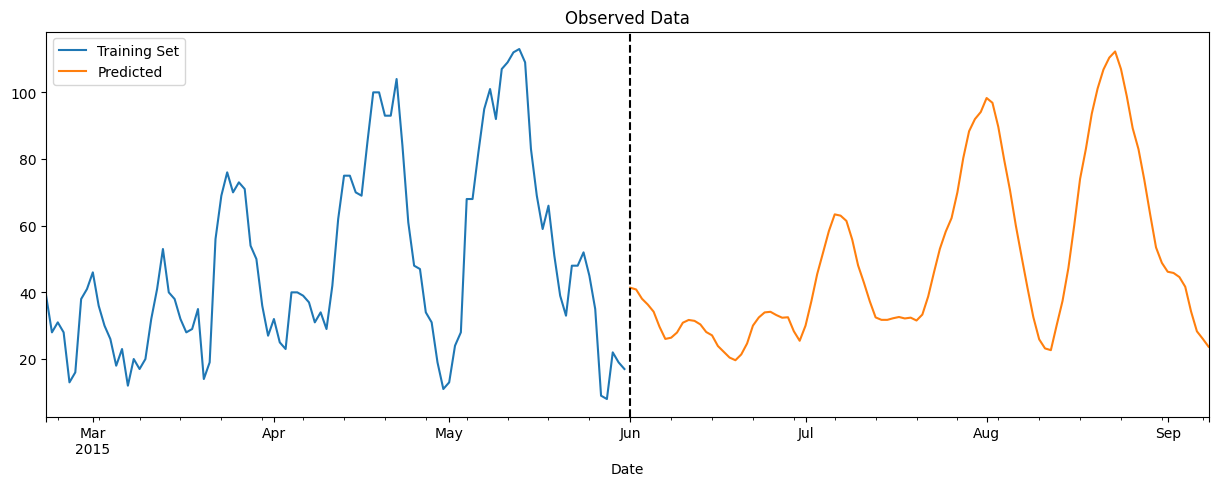

In [97]:
#9. Visualization

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
hist_data.plot(ax=ax, label='Training Data', title='Observed Data')
future_data.plot(ax=ax, label='Predicted')
ax.axvline('2015-06-01', color='black', ls='--')
ax.legend(['Training Set', 'Predicted'])
plt.show()